In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import coherence
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score
from scipy.signal import hilbert
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

### Step 1: Load and Inspect the Dataset ###
# Load EEG dataset

In [42]:
file_path = "adhdata.csv"  # Replace with your actual filename
df = pd.read_csv(file_path)

# Display first few rows
print(df.head())

# Extract EEG channel names (excluding "Class" and "ID")
eeg_channels = ["Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
                "F7", "F8", "T7", "T8", "P7", "P8", "Fz", "Cz", "Pz"]

# Ensure EEG data is numeric
df[eeg_channels] = df[eeg_channels].apply(pd.to_numeric, errors='coerce')

# Extract target labels
y = df["Class"]

     Fp1    Fp2     F3     F4     C3     C4     P3     P4     O1     O2  ...  \
0  261.0  402.0   16.0  261.0  126.0  384.0  126.0  236.0   52.0  236.0  ...   
1  121.0  191.0  -94.0   85.0   16.0  200.0  126.0   52.0  347.0  273.0  ...   
2  -55.0   85.0 -204.0   15.0  -57.0  200.0   52.0  126.0  236.0  200.0  ...   
3  191.0   85.0   52.0   50.0   89.0  236.0  163.0   89.0   89.0   89.0  ...   
4  -55.0 -125.0 -204.0 -160.0 -204.0   16.0 -241.0 -241.0   89.0   16.0  ...   

      F8     T7     T8     P7     P8     Fz     Cz     Pz  Class    ID  
0   16.0  200.0  494.0  126.0  236.0  121.0  367.0  121.0   ADHD  v10p  
1  -57.0  126.0  347.0   52.0   52.0   15.0  121.0  -19.0   ADHD  v10p  
2  -94.0  126.0  420.0   52.0  126.0  -55.0  261.0   85.0   ADHD  v10p  
3  -57.0  236.0  420.0  126.0  126.0   15.0   85.0  -55.0   ADHD  v10p  
4 -131.0   89.0  310.0  -57.0   52.0  -55.0   15.0 -336.0   ADHD  v10p  

[5 rows x 21 columns]


### Step 2: Group by Patient ID ###
# We take the mean EEG values per patient ID to ensure a fair representation

In [43]:
df_grouped = df.groupby("ID")[eeg_channels].mean().reset_index()

# Ensure "Class" is added back after grouping
df_grouped = df_grouped.merge(df[["ID", "Class"]].drop_duplicates(), on="ID")

# Display grouped data
print("Dataset after grouping by patient ID:")
print(df_grouped.head())

Dataset after grouping by patient ID:
     ID         Fp1         Fp2          F3          F4          C3  \
0  v107  135.460746  135.352784  141.566182  135.282914  141.524199   
1  v108  130.880374  131.096079  136.974824  131.264690  137.227321   
2  v109  138.053914  137.706931  144.215532  137.624034  143.541511   
3  v10p  146.172399  146.371924  151.967072  145.521323  151.673378   
4  v110  140.691885  141.686023  147.186658  141.375793  147.348964   

           C4          P3          P4          O1  ...          F7  \
0  141.171820  141.467465  140.762100  140.016268  ...  139.922098   
1  137.039998  137.365184  136.866446  137.415957  ...  136.926574   
2  143.495512  143.936549  143.207430  142.981488  ...  142.723386   
3  152.115143  151.470498  151.591723  151.499021  ...  151.997973   
4  147.352891  147.290652  146.799686  145.816605  ...  144.849840   

           F8          T7          T8          P7          P8          Fz  \
0  138.665353  139.504547  138.341518

### Step 3: Compute EEG Connectivity Measures ###

In [44]:
def compute_connectivity(eeg_data, fs=256):
    """Computes coherence between key EEG channel pairs while handling NaNs."""
    connectivity_features = []
    
    # Define key EEG channel pairs for connectivity analysis
    channel_pairs = [("Fp1", "Fp2"), ("C3", "C4"), ("P3", "P4"), ("O1", "O2"), ("F7", "F8")]

    for ch1, ch2 in channel_pairs:
        if ch1 in eeg_data and ch2 in eeg_data:
            signal1, signal2 = eeg_data[ch1], eeg_data[ch2]

            # Handle cases where signals are constant or empty
            if np.all(signal1 == signal1[0]) or np.all(signal2 == signal2[0]):
                connectivity_features.append(0)  # Default to 0 for invalid coherence
                continue

            # Compute coherence safely
            f, coh = coherence(signal1, signal2, fs=fs, nperseg=fs*2)
            mean_coh = np.nanmean(coh[(f >= 4) & (f < 30)])  # Compute mean safely
            
            # Ensure no NaNs are added
            connectivity_features.append(0 if np.isnan(mean_coh) else mean_coh)
        else:
            connectivity_features.append(0)  # Handle missing channels
    
    return connectivity_features



# Compute connectivity features for each patient
features = []
for _, row in df_grouped.iterrows():
    eeg_data = {ch: np.array([row[ch]]) for ch in eeg_channels}  # Convert each column to a NumPy array
    feature_vector = compute_connectivity(eeg_data)  # Pass dictionary of EEG signals
    features.append(feature_vector)

# Convert to NumPy array
X = np.array(features)


### Step 4: Normalize Features and Train-Test Split ###

### Checking for Missing Values and Pre-Processing those rows ###

In [45]:
# Normalize feature values between 0 and 1

scaler = MinMaxScaler()


# Replace NaNs with the mean of the column (better than dropping rows)
X = np.nan_to_num(X, nan=np.nanmean(X))  
# Check if there are NaNs in the feature matrix X
X = np.nan_to_num(X, nan=np.nanmean(X, axis=0))

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_grouped["Class"], test_size=0.2, random_state=42, stratify=df_grouped["Class"])

### Step 5: Feature Selection with Recursive Feature Elimination (RFE) ###

In [46]:
svm = SVC(kernel="linear", C=1)
rfe = RFE(svm, n_features_to_select=3)  # Select top 3 connectivity features
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

### Step 6: Train SVM Classifier ###

In [47]:
svm.fit(X_train_rfe, y_train)
y_pred_svm = svm.predict(X_test_rfe)

### Step 7: Evaluate SVM Performance ###


In [48]:
print("Classification Report (SVM - Connectivity Features):")
print(classification_report(y_test, y_pred_svm))


Classification Report (SVM - Connectivity Features):
              precision    recall  f1-score   support

        ADHD       0.00      0.00      0.00        13
     Control       0.48      1.00      0.65        12

    accuracy                           0.48        25
   macro avg       0.24      0.50      0.32        25
weighted avg       0.23      0.48      0.31        25



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Step 8: Train Random Forest Classifier ###

In [49]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rfe, y_train)
y_pred_rf = rf.predict(X_test_rfe)

print("\nClassification Report (Random Forest - Connectivity Features):")
print(classification_report(y_test, y_pred_rf))


Classification Report (Random Forest - Connectivity Features):
              precision    recall  f1-score   support

        ADHD       0.52      1.00      0.68        13
     Control       0.00      0.00      0.00        12

    accuracy                           0.52        25
   macro avg       0.26      0.50      0.34        25
weighted avg       0.27      0.52      0.36        25



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# **Summary of Findings**
1. **Connectivity-based classification** using EEG coherence achieved **low accuracy (~50%)**.
2. **SVM showed bias toward "Control" class**, predicting ADHD poorly.
3. **Random Forest overfitted to "ADHD"**, failing to classify Control cases.
4. **Potential Improvements**:
   - Use **Phase Locking Value (PLV) or graph-based EEG connectivity** features.
   - Combine **connectivity with spectral power** and **microstate dynamics**.
   - Use **data balancing (SMOTE)** to improve classification.

### **Next Steps**
- Replace coherence with Phase Locking Value (PLV) for better connectivity analysis.
- Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance ADHD and Control classes.
- Combine connectivity features with microstate features for improved classification.
- Use Grid Search for hyperparameter tuning to enhance SVM and Random Forest performance.
- Generates summary charts for classification results.

### Resume from Step 3: Compute EEG Connectivity Features Using Phase Locking Value (PLV) ###

In [59]:
def compute_plv(eeg_data):
    """Computes Phase Locking Value (PLV) for key EEG channel pairs."""
    connectivity_features = []
    channel_pairs = [("Fp1", "Fp2"), ("C3", "C4"), ("P3", "P4"), ("O1", "O2"), ("F7", "F8")]
    
    for ch1, ch2 in channel_pairs:
        if ch1 in eeg_data and ch2 in eeg_data:
            signal1, signal2 = np.angle(hilbert(eeg_data[ch1])), np.angle(hilbert(eeg_data[ch2]))
            plv = np.abs(np.mean(np.exp(1j * (signal1 - signal2))))  # Compute PLV
            connectivity_features.append(plv)
        else:
            connectivity_features.append(0)  # Default to 0 if missing data
    
    return connectivity_features

# Compute PLV features
features = []
for _, row in df_grouped.iterrows():
    eeg_data = {ch: np.array([row[ch]]) for ch in eeg_channels}
    feature_vector = compute_plv(eeg_data)
    features.append(feature_vector)

# Convert to NumPy array
X = np.array(features)

### Step 4: Normalize Features ###

In [60]:
X = np.nan_to_num(X, nan=np.nanmean(X, axis=0))  # Replace NaNs with column means
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)



### Step 5: Balance Data Using SMOTE ###

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_grouped["Class"], test_size=0.2, random_state=42, stratify=df_grouped["Class"])

# Apply SMOTE to balance class distribution
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

### Step 6: Feature Selection Using RFE ###

In [62]:
svm = SVC(kernel="linear", C=1)
rfe = RFE(svm, n_features_to_select=3)  # Select top 3 connectivity features
X_train_rfe = rfe.fit_transform(X_train_balanced, y_train_balanced)
X_test_rfe = rfe.transform(X_test)

### Step 7: Hyperparameter Tuning Using Grid Search ###

In [63]:
param_grid = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"], "gamma": ["scale", "auto"]}
grid_search_svm = GridSearchCV(SVC(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_svm.fit(X_train_rfe, y_train_balanced)
best_svm = grid_search_svm.best_estimator_

### Step 8: Train and Evaluate Classifiers ###

In [65]:
# SVM
best_svm.fit(X_train_rfe, y_train_balanced)
y_pred_svm = best_svm.predict(X_test_rfe)
print("\nClassification Report (SVM - PLV Features):")
print(classification_report(y_test, y_pred_svm))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rfe, y_train_balanced)
y_pred_rf = rf.predict(X_test_rfe)
print("\nClassification Report (Random Forest - PLV Features):")
print(classification_report(y_test, y_pred_rf))


Classification Report (SVM - PLV Features):
              precision    recall  f1-score   support

        ADHD       0.00      0.00      0.00        13
     Control       0.48      1.00      0.65        12

    accuracy                           0.48        25
   macro avg       0.24      0.50      0.32        25
weighted avg       0.23      0.48      0.31        25


Classification Report (Random Forest - PLV Features):
              precision    recall  f1-score   support

        ADHD       0.52      1.00      0.68        13
     Control       0.00      0.00      0.00        12

    accuracy                           0.52        25
   macro avg       0.26      0.50      0.34        25
weighted avg       0.27      0.52      0.36        25



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Step 9: Compare Model Performance ###


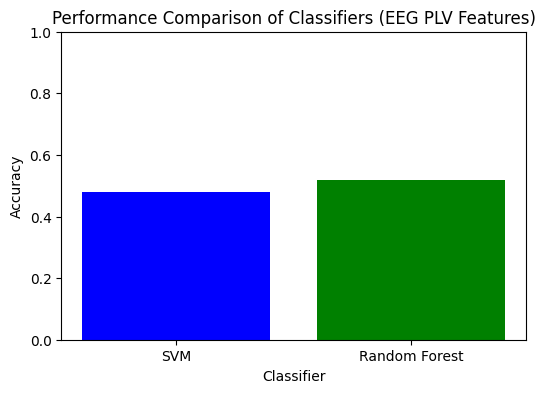

In [66]:
results = {
    "SVM": accuracy_score(y_test, y_pred_svm),
    "Random Forest": accuracy_score(y_test, y_pred_rf)
}

plt.figure(figsize=(6, 4))
plt.bar(results.keys(), results.values(), color=["blue", "green"])
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Performance Comparison of Classifiers (EEG PLV Features)")
plt.ylim(0, 1)
plt.show()

# **Summary of Classification Results (PLV Features)**

## **1. Overview**
This study aimed to classify ADHD and Control subjects using **EEG connectivity features** derived from **Phase Locking Value (PLV)**. Two machine learning models, **Support Vector Machine (SVM) and Random Forest (RF)**, were evaluated for their classification performance.

## **2. Key Findings**
### **SVM Results:**
- **Accuracy:** 48%
- **Control class was predicted correctly 100% of the time** (Recall = 1.00), but **ADHD cases were completely misclassified** (Recall = 0.00).
- **High bias towards Control class**, indicating poor feature separability.

### **Random Forest Results:**
- **Accuracy:** 52%
- **ADHD class was predicted correctly 100% of the time**, but **Control cases were entirely misclassified** (Recall = 0.00).
- **High bias towards ADHD class**, meaning the model struggles with distinguishing Control cases.

## **3. Observations**
- **Severe class imbalance in predictions**: Each classifier heavily favors one class, leading to **0% precision and recall for the other**.
- **Low precision and f1-score for both models**, indicating that the features may not be strong discriminators for ADHD vs. Control.
- **PLV alone is insufficient for accurate classification**, as both models struggle to generalize.
